In [1]:
EXPERIMENT = '02-02'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features

In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
X_test.drop(columns=amenity_onehot_features, inplace=True)

# Cross validation

## Preparation

In [13]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [14]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [15]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [16]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [17]:
train.set_index('id', inplace=True)

## Training models

In [18]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    with timer('Training', logger):
        estimator = CatBoostRegressor(n_estimators=300, random_state=SEED,
                                      train_dir=os.path.join(output_dir, f'fold{num_fold}'),
                                      cat_features=discrete_features)
        estimator.fit(X_train, y_train)
    
    # 予測結果を保存する
    with timer('Prediction', logger):
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_test = pd.DataFrame(data=estimator.predict(X_test.drop(columns=['id'])), columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump(estimator, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.191486
0:	learn: 0.6510974	total: 202ms	remaining: 1m
1:	learn: 0.6005517	total: 266ms	remaining: 39.7s
2:	learn: 0.5623600	total: 325ms	remaining: 32.1s
3:	learn: 0.5335450	total: 386ms	remaining: 28.5s
4:	learn: 0.5054624	total: 448ms	remaining: 26.4s
5:	learn: 0.4848925	total: 503ms	remaining: 24.7s
6:	learn: 0.4695855	total: 571ms	remaining: 23.9s
7:	learn: 0.4584431	total: 633ms	remaining: 23.1s
8:	learn: 0.4499743	total: 694ms	remaining: 22.4s
9:	learn: 0.4440962	total: 758ms	remaining: 22s
10:	learn: 0.4385556	total: 819ms	remaining: 21.5s
11:	learn: 0.4334556	total: 886ms	remaining: 21.3s
12:	learn: 0.4287111	total: 946ms	remaining: 20.9s
13:	learn: 0.4253267	total: 1.01s	remaining: 20.6s
14:	learn: 0.4220500	total: 1.07s	remaining: 20.3s
15:	learn: 0.4194672	total: 1.12s	remaining: 19.9s
16:	learn: 0.4176913	total: 1.19s	remaining: 19.8s
17:	learn: 0.4157554	total: 1.24s	remaining: 19.5s
18:	learn: 0.4139911	total: 1.3s	remaining: 19.3s
19:	learn: 0.4126

161:	learn: 0.3602576	total: 10.3s	remaining: 8.79s
162:	learn: 0.3600642	total: 10.4s	remaining: 8.72s
163:	learn: 0.3599360	total: 10.4s	remaining: 8.65s
164:	learn: 0.3598079	total: 10.5s	remaining: 8.58s
165:	learn: 0.3596101	total: 10.5s	remaining: 8.51s
166:	learn: 0.3593276	total: 10.6s	remaining: 8.44s
167:	learn: 0.3592312	total: 10.7s	remaining: 8.37s
168:	learn: 0.3590733	total: 10.7s	remaining: 8.3s
169:	learn: 0.3589664	total: 10.8s	remaining: 8.23s
170:	learn: 0.3587461	total: 10.8s	remaining: 8.16s
171:	learn: 0.3585205	total: 10.9s	remaining: 8.11s
172:	learn: 0.3584202	total: 10.9s	remaining: 8.04s
173:	learn: 0.3582349	total: 11s	remaining: 7.98s
174:	learn: 0.3580623	total: 11.1s	remaining: 7.91s
175:	learn: 0.3580160	total: 11.1s	remaining: 7.84s
176:	learn: 0.3578441	total: 11.2s	remaining: 7.78s
177:	learn: 0.3576943	total: 11.3s	remaining: 7.71s
178:	learn: 0.3574865	total: 11.3s	remaining: 7.66s
179:	learn: 0.3573628	total: 11.4s	remaining: 7.59s
180:	learn: 0.3

21:	learn: 0.4079825	total: 1.25s	remaining: 15.9s
22:	learn: 0.4065469	total: 1.31s	remaining: 15.8s
23:	learn: 0.4052152	total: 1.36s	remaining: 15.6s
24:	learn: 0.4042649	total: 1.41s	remaining: 15.6s
25:	learn: 0.4034299	total: 1.48s	remaining: 15.6s
26:	learn: 0.4026814	total: 1.53s	remaining: 15.4s
27:	learn: 0.4014469	total: 1.59s	remaining: 15.4s
28:	learn: 0.4007810	total: 1.65s	remaining: 15.4s
29:	learn: 0.4000372	total: 1.71s	remaining: 15.4s
30:	learn: 0.3993430	total: 1.76s	remaining: 15.3s
31:	learn: 0.3983200	total: 1.82s	remaining: 15.2s
32:	learn: 0.3973818	total: 1.9s	remaining: 15.3s
33:	learn: 0.3967262	total: 1.95s	remaining: 15.3s
34:	learn: 0.3959098	total: 2.01s	remaining: 15.3s
35:	learn: 0.3953641	total: 2.07s	remaining: 15.2s
36:	learn: 0.3949314	total: 2.13s	remaining: 15.1s
37:	learn: 0.3942539	total: 2.18s	remaining: 15s
38:	learn: 0.3938419	total: 2.23s	remaining: 14.9s
39:	learn: 0.3934323	total: 2.28s	remaining: 14.8s
40:	learn: 0.3928387	total: 2.34s	

182:	learn: 0.3562776	total: 10.9s	remaining: 7s
183:	learn: 0.3562731	total: 11s	remaining: 6.95s
184:	learn: 0.3560316	total: 11.1s	remaining: 6.9s
185:	learn: 0.3559514	total: 11.2s	remaining: 6.84s
186:	learn: 0.3556607	total: 11.2s	remaining: 6.79s
187:	learn: 0.3554795	total: 11.3s	remaining: 6.73s
188:	learn: 0.3552043	total: 11.4s	remaining: 6.67s
189:	learn: 0.3551698	total: 11.4s	remaining: 6.61s
190:	learn: 0.3550343	total: 11.5s	remaining: 6.55s
191:	learn: 0.3549098	total: 11.6s	remaining: 6.5s
192:	learn: 0.3547632	total: 11.6s	remaining: 6.44s
193:	learn: 0.3545257	total: 11.7s	remaining: 6.37s
194:	learn: 0.3544072	total: 11.7s	remaining: 6.31s
195:	learn: 0.3543210	total: 11.8s	remaining: 6.25s
196:	learn: 0.3542172	total: 11.8s	remaining: 6.19s
197:	learn: 0.3539359	total: 11.9s	remaining: 6.13s
198:	learn: 0.3537864	total: 11.9s	remaining: 6.06s
199:	learn: 0.3536032	total: 12s	remaining: 6s
200:	learn: 0.3534025	total: 12.1s	remaining: 5.94s
201:	learn: 0.3529934	to

43:	learn: 0.3917436	total: 2.89s	remaining: 16.8s
44:	learn: 0.3914273	total: 2.95s	remaining: 16.7s
45:	learn: 0.3908211	total: 3.02s	remaining: 16.7s
46:	learn: 0.3904630	total: 3.08s	remaining: 16.6s
47:	learn: 0.3901705	total: 3.14s	remaining: 16.5s
48:	learn: 0.3897456	total: 3.2s	remaining: 16.4s
49:	learn: 0.3892861	total: 3.29s	remaining: 16.5s
50:	learn: 0.3887179	total: 3.36s	remaining: 16.4s
51:	learn: 0.3883404	total: 3.42s	remaining: 16.3s
52:	learn: 0.3878438	total: 3.48s	remaining: 16.2s
53:	learn: 0.3875649	total: 3.54s	remaining: 16.1s
54:	learn: 0.3871289	total: 3.62s	remaining: 16.1s
55:	learn: 0.3866166	total: 3.7s	remaining: 16.1s
56:	learn: 0.3864203	total: 3.76s	remaining: 16s
57:	learn: 0.3858672	total: 3.8s	remaining: 15.9s
58:	learn: 0.3855348	total: 3.85s	remaining: 15.7s
59:	learn: 0.3850763	total: 3.9s	remaining: 15.6s
60:	learn: 0.3845782	total: 3.95s	remaining: 15.5s
61:	learn: 0.3841426	total: 4.01s	remaining: 15.4s
62:	learn: 0.3837422	total: 4.08s	rem

203:	learn: 0.3530580	total: 12.8s	remaining: 6.04s
204:	learn: 0.3528678	total: 12.9s	remaining: 5.97s
205:	learn: 0.3526228	total: 13s	remaining: 5.91s
206:	learn: 0.3524565	total: 13s	remaining: 5.85s
207:	learn: 0.3522317	total: 13.1s	remaining: 5.78s
208:	learn: 0.3521746	total: 13.1s	remaining: 5.72s
209:	learn: 0.3520254	total: 13.2s	remaining: 5.65s
210:	learn: 0.3519700	total: 13.3s	remaining: 5.59s
211:	learn: 0.3518261	total: 13.3s	remaining: 5.53s
212:	learn: 0.3516212	total: 13.4s	remaining: 5.48s
213:	learn: 0.3514742	total: 13.5s	remaining: 5.42s
214:	learn: 0.3512436	total: 13.6s	remaining: 5.36s
215:	learn: 0.3510947	total: 13.6s	remaining: 5.29s
216:	learn: 0.3509517	total: 13.7s	remaining: 5.22s
217:	learn: 0.3508237	total: 13.7s	remaining: 5.16s
218:	learn: 0.3506532	total: 13.8s	remaining: 5.09s
219:	learn: 0.3506507	total: 13.8s	remaining: 5.02s
220:	learn: 0.3505040	total: 13.9s	remaining: 4.96s
221:	learn: 0.3504829	total: 13.9s	remaining: 4.89s
222:	learn: 0.35

64:	learn: 0.3809391	total: 4s	remaining: 14.4s
65:	learn: 0.3804245	total: 4.09s	remaining: 14.5s
66:	learn: 0.3800426	total: 4.16s	remaining: 14.5s
67:	learn: 0.3797984	total: 4.24s	remaining: 14.5s
68:	learn: 0.3795317	total: 4.32s	remaining: 14.4s
69:	learn: 0.3791209	total: 4.37s	remaining: 14.4s
70:	learn: 0.3789033	total: 4.43s	remaining: 14.3s
71:	learn: 0.3787029	total: 4.48s	remaining: 14.2s
72:	learn: 0.3785308	total: 4.58s	remaining: 14.3s
73:	learn: 0.3782078	total: 4.66s	remaining: 14.2s
74:	learn: 0.3780520	total: 4.73s	remaining: 14.2s
75:	learn: 0.3776655	total: 4.79s	remaining: 14.1s
76:	learn: 0.3773204	total: 4.85s	remaining: 14.1s
77:	learn: 0.3768973	total: 4.92s	remaining: 14s
78:	learn: 0.3764203	total: 4.98s	remaining: 13.9s
79:	learn: 0.3760312	total: 5.05s	remaining: 13.9s
80:	learn: 0.3757602	total: 5.12s	remaining: 13.8s
81:	learn: 0.3754665	total: 5.17s	remaining: 13.8s
82:	learn: 0.3751848	total: 5.24s	remaining: 13.7s
83:	learn: 0.3748427	total: 5.3s	rem

225:	learn: 0.3476588	total: 13.9s	remaining: 4.56s
226:	learn: 0.3474880	total: 14s	remaining: 4.49s
227:	learn: 0.3473632	total: 14s	remaining: 4.43s
228:	learn: 0.3471888	total: 14.1s	remaining: 4.37s
229:	learn: 0.3470327	total: 14.2s	remaining: 4.31s
230:	learn: 0.3469456	total: 14.2s	remaining: 4.25s
231:	learn: 0.3467967	total: 14.3s	remaining: 4.19s
232:	learn: 0.3466994	total: 14.3s	remaining: 4.12s
233:	learn: 0.3465470	total: 14.4s	remaining: 4.06s
234:	learn: 0.3464099	total: 14.5s	remaining: 4s
235:	learn: 0.3463788	total: 14.5s	remaining: 3.93s
236:	learn: 0.3462661	total: 14.6s	remaining: 3.87s
237:	learn: 0.3461769	total: 14.6s	remaining: 3.81s
238:	learn: 0.3460041	total: 14.7s	remaining: 3.75s
239:	learn: 0.3458403	total: 14.7s	remaining: 3.68s
240:	learn: 0.3457341	total: 14.8s	remaining: 3.62s
241:	learn: 0.3456566	total: 14.9s	remaining: 3.56s
242:	learn: 0.3455111	total: 14.9s	remaining: 3.5s
243:	learn: 0.3453477	total: 15s	remaining: 3.43s
244:	learn: 0.3452235	

87:	learn: 0.3718608	total: 5.46s	remaining: 13.2s
88:	learn: 0.3716061	total: 5.53s	remaining: 13.1s
89:	learn: 0.3714908	total: 5.58s	remaining: 13s
90:	learn: 0.3710701	total: 5.64s	remaining: 12.9s
91:	learn: 0.3706214	total: 5.72s	remaining: 12.9s
92:	learn: 0.3703755	total: 5.81s	remaining: 12.9s
93:	learn: 0.3701405	total: 5.89s	remaining: 12.9s
94:	learn: 0.3698644	total: 5.95s	remaining: 12.8s
95:	learn: 0.3697639	total: 6.01s	remaining: 12.8s
96:	learn: 0.3694749	total: 6.06s	remaining: 12.7s
97:	learn: 0.3692396	total: 6.12s	remaining: 12.6s
98:	learn: 0.3689914	total: 6.18s	remaining: 12.6s
99:	learn: 0.3688197	total: 6.24s	remaining: 12.5s
100:	learn: 0.3686209	total: 6.3s	remaining: 12.4s
101:	learn: 0.3684346	total: 6.36s	remaining: 12.3s
102:	learn: 0.3680221	total: 6.42s	remaining: 12.3s
103:	learn: 0.3677689	total: 6.48s	remaining: 12.2s
104:	learn: 0.3675730	total: 6.54s	remaining: 12.1s
105:	learn: 0.3672949	total: 6.59s	remaining: 12.1s
106:	learn: 0.3670809	total:

247:	learn: 0.3437679	total: 15.2s	remaining: 3.19s
248:	learn: 0.3436061	total: 15.3s	remaining: 3.13s
249:	learn: 0.3434563	total: 15.3s	remaining: 3.07s
250:	learn: 0.3433070	total: 15.4s	remaining: 3s
251:	learn: 0.3431421	total: 15.4s	remaining: 2.94s
252:	learn: 0.3429891	total: 15.5s	remaining: 2.88s
253:	learn: 0.3429238	total: 15.6s	remaining: 2.82s
254:	learn: 0.3427546	total: 15.7s	remaining: 2.76s
255:	learn: 0.3425405	total: 15.7s	remaining: 2.7s
256:	learn: 0.3423757	total: 15.8s	remaining: 2.64s
257:	learn: 0.3422158	total: 15.8s	remaining: 2.57s
258:	learn: 0.3420098	total: 15.9s	remaining: 2.51s
259:	learn: 0.3418526	total: 15.9s	remaining: 2.45s
260:	learn: 0.3416372	total: 16s	remaining: 2.39s
261:	learn: 0.3413506	total: 16s	remaining: 2.33s
262:	learn: 0.3411663	total: 16.1s	remaining: 2.27s
263:	learn: 0.3410491	total: 16.2s	remaining: 2.2s
264:	learn: 0.3408751	total: 16.2s	remaining: 2.14s
265:	learn: 0.3407356	total: 16.3s	remaining: 2.08s
266:	learn: 0.3406443

## Evaluation

In [19]:
rmse = partial(mse, squared=False)

In [20]:
metrics = defaultdict(list)

### Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-03 22:32:12,538 - __main__ - INFO - CV fold 1 training loss=97.9688229
2021-08-03 22:32:12,562 - __main__ - INFO - CV fold 2 training loss=96.3817595
2021-08-03 22:32:12,589 - __main__ - INFO - CV fold 3 training loss=95.8098659
2021-08-03 22:32:12,614 - __main__ - INFO - CV fold 4 training loss=95.6004651
2021-08-03 22:32:12,638 - __main__ - INFO - CV fold 5 training loss=94.9115376
2021-08-03 22:32:12,639 - __main__ - INFO - CV training loss: average=96.1344902, std=1.0307372


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [23]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-03 22:32:12,863 - __main__ - INFO - Training loss: 110.8218399


### Validation set

In [24]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-03 22:32:12,901 - __main__ - INFO - CV fold 1 validation loss=102.0250686
2021-08-03 22:32:12,930 - __main__ - INFO - CV fold 2 validation loss=105.0525044
2021-08-03 22:32:12,948 - __main__ - INFO - CV fold 3 validation loss=107.9212540
2021-08-03 22:32:12,995 - __main__ - INFO - CV fold 4 validation loss=108.2150094
2021-08-03 22:32:13,012 - __main__ - INFO - CV fold 5 validation loss=110.3921947
2021-08-03 22:32:13,014 - __main__ - INFO - CV validation loss: average=106.7212062, std=2.8977920


In [25]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [26]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-03 22:32:13,226 - __main__ - INFO - Validation loss: 199.2757502


In [27]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


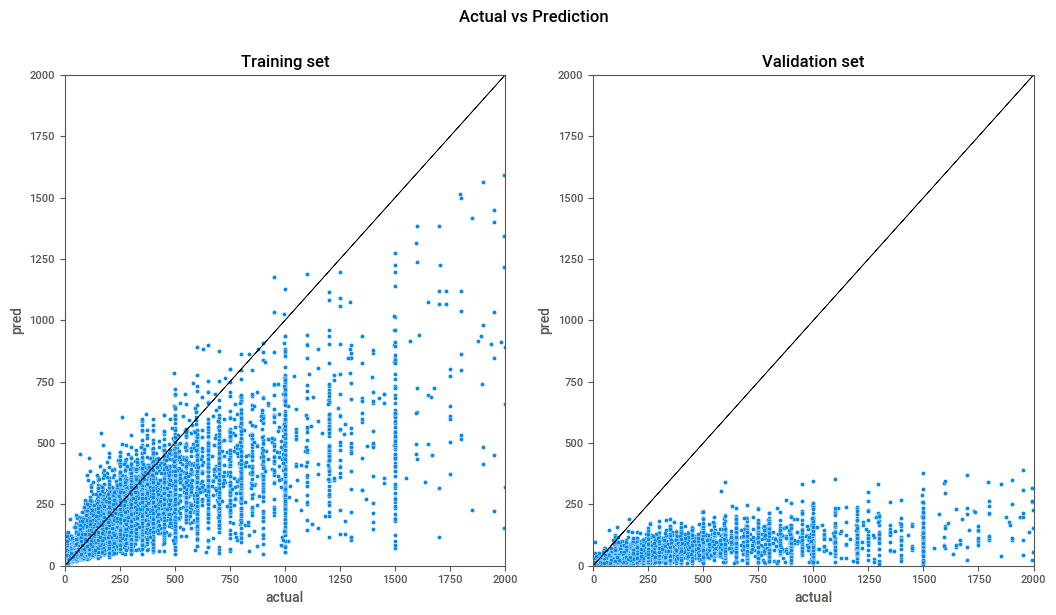

In [59]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

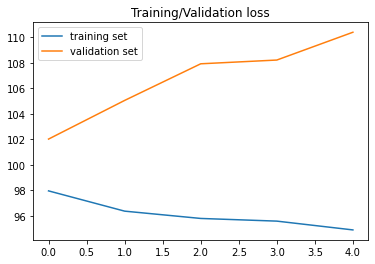

In [29]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [30]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [32]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

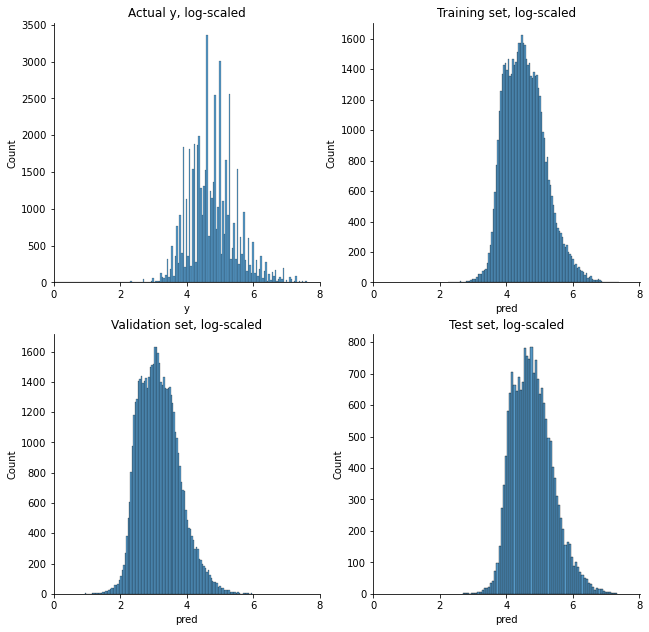

In [33]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [34]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [35]:
pd.options.display.float_format = '{:.5f}'.format

In [36]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

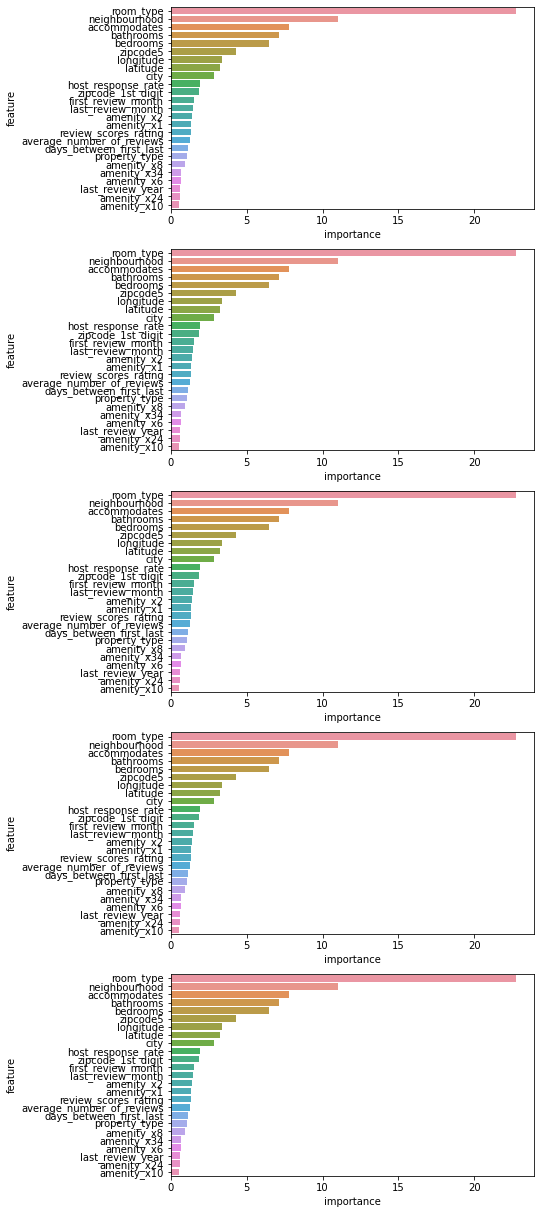

In [37]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
    imp_df['feature'] = model.feature_names_
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance.png'))

# Error

In [38]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [39]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

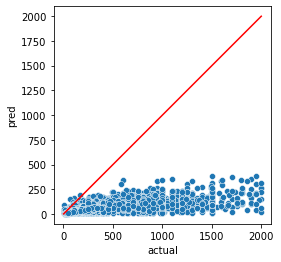

In [40]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

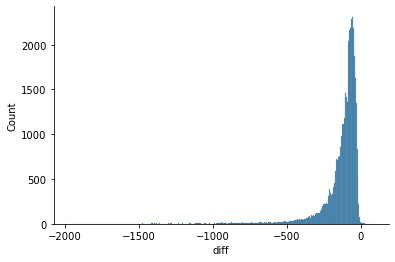

In [41]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [42]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [43]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\02-02\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 42.2 s


In [44]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [45]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40313,2,1.00000,0,1.00000,1.00000,1,3,0,1,1,100.00000,0,37.78704,-122.49322,484,0,1,NaN,0,NaN,NaN,0.00000,NaN,0,230,0,0,NaN,NaN,2015.00000,2.00000,NaN,NaN,-0.98598,-0.50971,-0.14381,0.88011,0.47020,-1.66575,0.36894,0.86084,-1.32572,0.84898,0.19969,1.20966,1.38035,-0.47130,-1.38793,1.03756,0.38361,-0.72492,0.50182,0.91009,0.26756,0.71786,-0.58625,-2.28689,0.68518,0.12817,0.06612,0.22450,0.39649,0.34178,1.44407,0.16081,2.11919,0.06188,-2.36979,0.55196,0.27265,0.06530,-1972.80613
47605,6,1.00000,0,1.00000,2.00000,1,1,0,1,1,NaN,0,38.94702,-77.06670,0,0,0,NaN,1,NaN,NaN,NaN,NaN,1,173,0,1,NaN,NaN,2016.00000,10.00000,NaN,NaN,0.38091,-1.19078,0.16443,-0.29578,0.04778,0.15948,-0.39985,0.80960,-0.82892,0.63717,0.37031,-0.34802,-0.10257,-1.76990,1.18775,0.17927,-1.10240,2.94742,-0.23480,-0.09212,1.58036,-0.67200,-0.36530,2.40120,0.46229,-1.05436,0.11241,-1.21491,0.59251,0.00917,-1.97233,-0.37667,0.50707,1.40186,0.56615,-0.03328,-0.06649,-0.72734,-1941.65014
39193,2,1.00000,0,1.00000,2.00000,0,1,0,1,0,NaN,0,38.90100,-77.05266,157,0,0,NaN,1,NaN,NaN,NaN,NaN,1,190,0,1,NaN,NaN,2015.00000,7.00000,NaN,NaN,-0.56563,-1.24281,0.07309,0.63217,-1.41470,1.07756,1.03968,0.31754,-0.35316,-1.11792,2.08714,-0.02670,-0.49698,0.35851,-0.51328,-0.43282,1.99117,-0.02885,-2.02410,0.71287,0.41960,-1.50930,-0.59762,-0.55203,1.76152,-0.43510,0.79823,-0.80358,1.00305,-0.59577,-1.45517,0.39382,-0.06063,1.67763,-0.09686,0.08749,-0.24695,-0.68558,-1906.56420
6546,7,3.50000,0,4.00000,4.00000,1,2,1,1,0,80.00000,1,40.73300,-73.99413,53,1,2,80.00000,1,1.00000,1.00000,80.00000,80.00000,2,76,0,0,2017.00000,9.00000,2017.00000,8.00000,2017.00000,9.00000,0.86847,-0.51094,0.22896,0.16245,0.07859,-2.21560,0.07953,-1.25213,-0.96756,-0.68603,0.78762,2.10228,-1.70732,-0.50109,-0.44391,-0.61956,0.19648,0.07444,1.59189,-0.83342,0.71830,0.08947,2.25701,0.13940,0.11526,0.46105,0.65242,0.63776,-1.53610,2.12993,0.10534,0.07536,-0.51511,0.72090,-0.82193,-1.09488,-1.74955,-0.63027,-1847.14683
32242,8,4.50000,0,5.00000,6.00000,1,1,0,1,1,100.00000,0,38.92856,-77.05729,191,2,1,100.00000,1,51.00000,0.03922,200.00000,3.92157,1,173,0,0,2017.00000,1.00000,2013.00000,2.00000,2017.00000,3.00000,-1.07560,-1.02032,0.04962,1.06593,-0.57607,-0.87461,0.70112,-0.77097,-0.22103,-0.32672,0.68676,-0.46312,-1.19127,-0.86707,-1.55350,-0.04270,1.70808,-1.73543,-0.94133,-0.61216,0.50509,0.29591,-0.37750,0.80785,-0.81186,-0.83585,-0.81121,0.79925,-0.26667,-0.13911,0.33755,1.81960,-0.17262,0.26699,-0.50794,0.27039,-0.15084,-0.10350,-1846.81951
28682,16,8.00000,0,7.00000,16.00000,2,0,1,1,0,73.00000,1,33.99476,-117.99379,0,0,1,NaN,1,NaN,NaN,0.00000,NaN,0,126,0,0,NaN,NaN,2016.00000,8.00000,NaN,NaN,1.21917,-0.34786,-0.46218,-0.13039,-0.31217,-0.65839,0.67999,-0.06798,-0.40348,1.58463,-0.87846,-0.26816,-1.85818,0.55555,0.71951,0.67072,-1.92523,-2.30622,-0.78387,-0.85216,-0.37737,0.27616,2.52349,-0.82094,-0.95008,-0.81766,0.56398,-1.36653,0.24233,-1.49768,0.80736,0.34635,-0.00314,-0

In [46]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38978,4,2.00000,0,1.00000,4.00000,0,1,0,1,1,100.00000,1,38.91209,-77.00355,285,41,0,96.00000,2,343.00000,0.11953,4100.00000,11.95335,1,43,0,0,2016.00000,5.00000,2016.00000,3.00000,2017.00000,5.00000,1.46839,-1.44864,-0.08680,-0.26928,-0.76829,0.20771,0.52473,-0.89871,-0.13278,0.82667,1.91167,-0.01674,2.00367,-0.76120,1.14923,-0.69022,0.89325,1.33037,0.55720,0.33158,0.15905,0.38592,-1.01621,-0.24252,-0.59276,-1.11789,-0.50887,-0.47617,0.80901,-0.02823,0.02612,0.31904,-0.31948,2.61634,-0.16805,-0.12855,0.51598,-1.43120,1.80199
30028,1,0.00000,0,1.00000,1.00000,2,0,0,1,0,NaN,0,34.05457,-118.37962,175,0,0,NaN,0,NaN,NaN,NaN,NaN,0,122,0,1,NaN,NaN,2013.00000,5.00000,NaN,NaN,-2.25416,0.28279,0.59938,-0.44047,0.88632,-0.95332,1.26030,1.64052,-0.09113,-1.47099,1.42681,-0.69864,0.84050,-0.34395,0.82150,0.04666,0.74807,0.58935,1.20028,0.27331,0.82556,0.37180,0.09227,1.19172,1.10463,-0.63793,0.57818,-1.67515,0.40653,0.41650,1.63316,0.22515,-0.10693,-0.05368,-0.27743,0.15908,-0.34692,-0.11389,1.84757
49641,1,1.00000,0,1.00000,1.00000,0,2,0,1,0,0.00000,0,40.63321,-73.93926,63,0,1,NaN,0,NaN,NaN,0.00000,NaN,2,199,0,0,NaN,NaN,2013.00000,12.00000,NaN,NaN,-0.29566,0.25926,-1.70589,1.06176,1.93485,0.41895,0.04316,1.26400,0.74240,0.29075,0.78375,2.49300,-1.74160,0.95880,1.05761,0.61854,0.60377,1.73576,-1.46871,1.32850,1.42497,-0.34798,-1.54371,-1.07328,1.10265,0.91683,1.63375,-1.51981,0.61438,-0.04373,-2.02471,0.05154,-0.38903,0.18871,0.25530,0.03742,-0.45474,-0.22687,1.89664
52878,4,0.00000,0,1.00000,2.00000,0,4,0,1,1,100.00000,0,42.01283,-87.70339,0,0,8,NaN,2,NaN,NaN,0.00000,NaN,3,308,0,0,NaN,NaN,2014.00000,1.00000,NaN,NaN,-1.86971,0.02570,0.94057,-0.93406,-0.17782,-1.28364,0.80957,0.96344,0.30805,0.21952,-1.11099,-1.49944,1.12825,0.92298,0.65897,-0.63676,-0.31099,0.17402,0.63078,1.04744,-0.07368,-0.26646,-0.76536,0.75453,0.14783,-0.45762,-0.57202,-0.48490,-0.41556,0.61492,2.69218,0.70684,-0.15332,-0.22087,-0.27172,0.12356,-0.11494,-0.13710,2.75386
7223,2,1.00000,0,1.00000,1.00000,0,2,0,1,1,NaN,0,40.69974,-73.91935,2,0,0,NaN,0,NaN,NaN,NaN,NaN,2,155,0,0,NaN,NaN,2016.00000,3.00000,NaN,NaN,-1.56574,0.47943,0.41331,-0.64226,-0.70949,-0.69637,0.03704,0.12430,0.95436,0.32060,-0.06994,-1.47390,-0.01494,-0.15144,-0.20460,0.05859,2.49555,-0.70679,-0.40011,1.12069,-0.61474,-0.55189,0.10590,1.54268,-0.13568,-0.57223,-0.63952,-0.37559,-0.73702,0.48434,1.34613,1.54944,1.55170,0.00018,-2.00305,0.60998,0.11968,-0.12227,3.16715
20773,2,1.00000,0,1.00000,1.00000,0,1,0,1,0,100.00000,0,38.91184,-77.03602,68,18,0,99.00000,0,50.00000,0.36000,1800.00000,36.00000,1,49,0,0,2017.00000,3.00000,2015.00000,5.00000,2017.00000,5.00000,0.77509,-0.70440,-0.47862,0.15923,0.23100,0.92776,-0.15411,-0.09605,1.21792,-1.61157,-0.64270,-0.96309,-1.22722,-0.11647,-0.46446,-2.20143,-0.55356,-1.05856,1.35622,0.18391,-1.63935,-2.06540,-0.50345,0.24001,-0.06721,3.17473,-0.69180,-1.72746,1.52825,0.16297,0.83403,-1.43608,0.51040,-0.03106,-0.18255,-0.28213,

In [47]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
accommodates,1.00000,0.50228,-0.08076,0.70851,0.80665,0.08614,-0.03374,0.18138,0.00384,0.06027,0.04945,0.05407,-0.07940,-0.08637,0.03845,0.04232,0.05381,-0.01782,0.38343,0.01715,-0.05569,0.00949,-0.01717,-0.05666,0.01619,0.00236,0.09432,0.00803,-0.00880,0.01172,-0.00375,0.07607,-0.07254,0.32613,-0.22656,0.20457,-0.10759,-0.00809,-0.05687,0.07716,-0.04722,-0.08642,0.02136,0.04140,-0.04151,-0.07542,-0.02078,0.02978,-0.04894,-0.08156,-0.06784,0.05432,0.02015,0.00074,-0.03073,0.04875,0.03728,0.02142,0.02310,0.01081,0.02520,-0.05594,0.05070,-0.01189,0.00525,-0.04034,-0.01938,-0.00067,-0.00194,0.09633,0.04063,-0.47733
bathrooms,0.50228,1.00000,-0.04213,0.58637,0.52485,0.00676,-0.08512,0.05268,0.00337,0.01460,0.00832,0.00227,-0.13543,-0.13205,0.04363,-0.04026,0.08669,0.00670,0.14528,-0.01355,-0.00016,-0.05742,0.01634,-0.11170,0.03302,0.00054,0.09641,-0.00405,-0.00779,0.00421,-0.00931,-0.01251,-0.07239,0.19000,-0.19280,0.01686,0.04469,0.04636,-0.05191,0.10045,-0.05508,-0.03281,-0.02070,0.06291,0.00523,-0.02622,-0.02429,-0.03797,-0.02364,-0.03043,-0.02077,0.06198,0.02433,-0.01993,-0.07117,0.04436,0.04287,0.01111,0.08646,0.03325,0.02105,-0.08169,0.00970,0.01000,0.01974,-0.02602,-0.04355,0.00068,0.00586,0.05893,0.03825,-0.41803
bed_type,-0.08076,-0.04213,1.00000,-0.05730,-0.06937,-0.01374,-0.00455,-0.03315,0.00240,-0.00789,-0.00663,-0.02723,-0.00474,-0.00500,0.01471,0.00200,0.01022,-0.00117,0.03653,0.02239,0.00321,0.01340,-0.01467,-0.00421,0.01086,0.00478,-0.01255,-0.04064,0.01269,-0.02198,0.00009,-0.03797,0.00604,-0.05462,0.01483,-0.03597,0.02053,0.03427,0.01641,0.02032,0.03345,0.04186,0.00394,-0.00378,0.01511,0.02272,-0.00916,0.00063,0.01716,0.00149,-0.00908,0.00248,-0.00736,0.00815,-0.00521,0.00285,0.01087,-0.01981,-0.00000,-0.01887,-0.00761,0.01659,0.00663,0.00709,-0.00858,0.00507,0.00575,0.00724,-0.00412,0.00803,0.00910,0.04762
bedrooms,0.70851,0.58637,-0.05730,1.00000,0.70823,0.03397,-0.00920,0.10670,0.00376,0.02643,0.02195,-0.00085,-0.05750,-0.07403,0.04969,-0.03376,0.01065,0.01000,0.19843,0.01198,-0.02189,-0.05325,-0.01011,-0.04382,0.02457,0.00363,0.08929,-0.01360,-0.00546,-0.00969,-0.01079,0.00636,-0.03339,0.22553,-0.19337,0.12983,-0.02649,0.04372,-0.06023,0.10917,-0.02858,-0.07612,-0.01690,0.01331,0.01129,-0.07899,-0.04359,-0.03945,-0.03975,-0.06690,-0.04431,0.06887,0.02578,-0.02159,-0.05602,0.03855,0.03055,0.01728,0.06128,0.02469,0.02197,-0.07531,0.01923,-0.01901,0.00833,-0.04115,-0.04338,0.00735,0.02500,0.06103,0.02991,-0.45341
beds,0.80665,0.52485,-0.06937,0.70823,1.00000,0.05970,-0.04259,0.13184,0.00671,0.03730,0.04351,0.05400,-0.08031,-0.08243,0.03877,0.03091,0.06647,-0.02784,0.32678,0.01385,-0.04168,0.00297,-0.01191,-0.05884,0.03434,0.00432,0.06445,0.00846,-0.00329,0.02708,-0.00849,0.06435,-0.05074,0.28177,-0.17892,0.15987,-0.07462,0.02689,-0.05460,0.08320,-0.02719,-0.06955,0.00161,0.04765,-0.03567,-0.06582,-0.03042,0.00646,-0.03424,-0.07219,-0.05943,0.05570,0.02920,-0.01820,-0.02881,0.02912,0.03153,0.03337,0.03316,0.00884,0.03235,-0.04627,0.04434,-0.01601,0.0

In [48]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                      -0.47733
bedrooms                          -0.45341
bathrooms                         -0.41803
beds                              -0.39679
room_type                         -0.26870
amenity_x1                        -0.13698
amenity_x3                        -0.11450
has_thumbnail                     -0.11222
amenity_x26                       -0.06307
review_scores_rating              -0.06175
amenity_x19                       -0.05927
amenity_x24                       -0.05161
property_type                     -0.05076
amenity_x23                       -0.04235
amenity_x37                       -0.04211
amenity_x38                       -0.03801
amenity_x27                       -0.03765
neighbourhood                     -0.03174
amenity_x30                       -0.02967
amenity_x13                       -0.02749
days_between_first_last           -0.02682
amenity_x11                       -0.02359
amenity_x28                       -0.02184
cleaning_fe

In [49]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [50]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [51]:
imp_df['feature'] = estimator.feature_name_

In [52]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,984797812.30469,bedrooms
1,613212339.00000,bathrooms
0,535356076.89844,accommodates
13,296897138.39844,longitude
12,288953153.19531,latitude
...,...,...
27,437322.00000,first_review_year
2,230041.00000,bed_type
25,0.00000,zipcode_imputed
23,0.00000,zipcode_1st_digit


In [53]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)